In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv
/kaggle/input/notebook39f36a8308/__results__.html
/kaggle/input/notebook39f36a8308/__resultx__.html
/kaggle/input/notebook39f36a8308/__notebook__.ipynb
/kaggle/input/notebook39f36a8308/__output__.json
/kaggle/input/notebook39f36a8308/custom.css
/kaggle/input/notebook39f36a8308/__results___files/__results___47_0.png
/kaggle/input/notebook39f36a8308/__results___files/__results___10_0.png
/kaggle/input/notebook39f36a8308/__results___files/__results___24_0.png
/kaggle/input/notebook39f36a8308/__results___files/__results___49_0.png
/kaggle/input/notebook39f36a8308/__results___files/__results___42_0.png


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='unicode_escape')
train_data=df[['text','sentiment']]
train_data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
train_data.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [6]:
train_data=train_data.dropna()

In [7]:
train_data.isna().any()

text         False
sentiment    False
dtype: bool

In [8]:
unique_col=train_data['sentiment'].unique()
print(unique_col)

['neutral' 'negative' 'positive']


In [9]:
dict={unique_col[i]: i for i in range(3)}
print(dict)
train_data.replace(dict,inplace=True)    
train_data.head()

{'neutral': 0, 'negative': 1, 'positive': 2}


/tmp/ipykernel_19/2294453797.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data.replace(dict,inplace=True)


,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


In [10]:
X=train_data.iloc[:,0].str
y=train_data.iloc[:,1]
print(X)
print(y)

0        0
1        1
2        1
3        1
4        1
        ..
27476    1
27477    1
27478    2
27479    2
27480    0
Name: sentiment, Length: 27480, dtype: int64


In [11]:
lf=pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='unicode_escape')
test_data=lf[['text','sentiment']]
test_data.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [12]:
test_data=test_data.dropna()

In [13]:
train_data.isna().any()

text         False
sentiment    False
dtype: bool

In [14]:
test_data.replace(dict,inplace=True)    
test_data.head()

/tmp/ipykernel_19/293175770.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data.replace(dict,inplace=True)


,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,0
1,Shanghai is also really exciting (precisely -...,2
2,"Recession hit Veronique Branquinho, she has to...",1
3,happy bday!,2
4,http://twitpic.com/4w75p - I like it!!,2


In [15]:
X_test=test_data.iloc[:,0].str
y_test=np.array(test_data.iloc[:,1])

In [16]:
class ComplementNB:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None

    def fit(self, X, y):
        n_features = X.shape[1]
        n_classes = len(np.unique(y))
        self.class_log_prior_ = np.zeros(n_classes)
        self.feature_log_prob_ = np.zeros((n_classes, n_features))

        for c in range(n_classes):
            X_c = X[y != c]
            self.class_log_prior_[c] = np.log(X_c.shape[0] / X.shape[0])
            self.feature_log_prob_[c] = np.log((X_c.sum(axis=0) + 1) / (np.sum(X_c.sum(axis=0) + 1)))

        return self

    def predict(self, X):
        jll = np.dot(X.toarray(), self.feature_log_prob_.T) + self.class_log_prior_
        return np.argmin(jll, axis=1)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_data["text"])
X_test= vectorizer.transform(test_data["text"])

model = ComplementNB().fit(X, y)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.6689303904923599


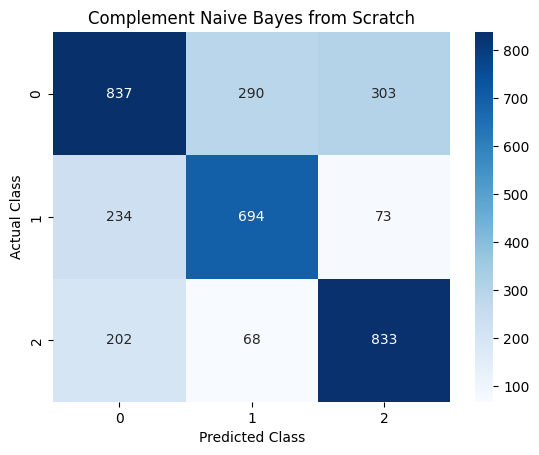

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Complement Naive Bayes from Scratch')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()

In [18]:
from sklearn.naive_bayes import ComplementNB

cnb=ComplementNB()
cnb.fit(X,y)
y_pred_cnb=cnb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_cnb)}')

Accuracy: 0.6533672891907187


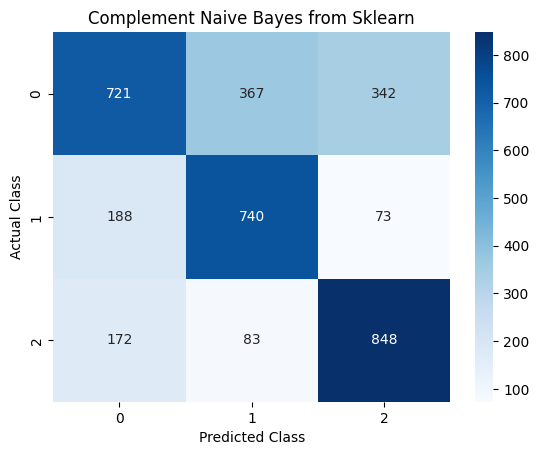

In [19]:
cm = confusion_matrix(y_test, y_pred_cnb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Complement Naive Bayes from Sklearn')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()